In [47]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import copy

from mpl_toolkits.mplot3d import Axes3D
import matplotlib

## Making Class for Soft But Hard Decision Tree - Static Building/End2End

Here (B), we use seperate input size for each node, hence optimization might be unstable

In [34]:
class LeafNode(object):
    
    def __init__(self, output_dim, optimizer):
        self.output_dim = output_dim
        self.optimizer = optimizer
        self.constant = tnn.BiasLayer(self.output_dim, optimizer=self.optimizer)
        
    def forward(self, inputs):
        out = np.zeros(shape=(inputs.shape[0], self.output_dim))
        return self.constant.forward(out)
    
    def backward(self, del_outputs):
        self.constant.backward(del_outputs)
        return del_outputs
    
    def update(self):
        self.constant.update()

class DecisionNode(object):
    
    def __init__(self, input_dim, output_dim, optimizer):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.optimizer = optimizer
        
        self.node0 = None
        self.node1 = None
        self.linear = tnn.LinearLayer(input_dim, output_dim, optimizer=optimizer)
        self.linear.weights *= 0
        self.sigmoid = tnn.Sigmoid()
        
        self.mask = None
        self.out0 = None
        self.out1 = None
        self.lengths = None
        
    def forward(self, inputs):
        
        lout = self.linear.forward(inputs)
        self.sigmoid.forward(lout)
        
        self.mask = (lout>0).reshape(-1)
        output = np.empty(shape=(inputs.shape[0], self.output_dim))

        m = np.count_nonzero(self.mask)
        self.lengths = (m, len(self.mask)-m)
        if self.lengths[0] > 0:
            self.out0 = self.node0.forward(inputs[self.mask])
            output[self.mask] = self.out0
        if self.lengths[1] > 0:
            self.out1 = self.node1.forward(inputs[~self.mask])
            output[~self.mask] = self.out1
        
        return output
    
    def backward(self, del_outputs):
        if self.lengths[0] > 0:
            self.node0.backward(del_outputs[self.mask])
        if self.lengths[1] > 0:
            self.node1.backward(del_outputs[~self.mask])
        
        self.linear.backward(self.sigmoid.backward(del_outputs.mean(axis=1, keepdims=True)))
        return del_outputs
    
    def update(self):
        self.linear.update()
        if self.lengths[0] > 0:
            self.node0.update()
        if self.lengths[1] > 0:
            self.node1.update()
        
    def create_child(self, depth):
        if depth > 1:
            self.node0 = DecisionNode(self.input_dim, self.output_dim, self.optimizer)
            self.node1 = DecisionNode(self.input_dim, self.output_dim, self.optimizer)
            self.node0.create_child(depth-1)
            self.node1.create_child(depth-1)
        else:
            self.node0 = LeafNode(self.output_dim, self.optimizer)
            self.node1 = LeafNode(self.output_dim, self.optimizer)

## 1D regression

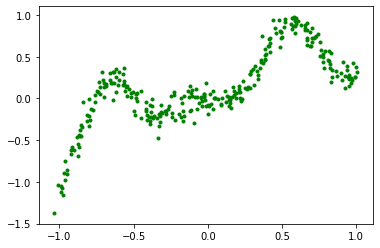

In [35]:
x = np.linspace(0,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

In [36]:
optimizer = tnn.Adam()
hdt = DecisionNode(1, 1, optimizer)
hdt.create_child(depth=3)

In [37]:
yout = hdt.forward(xx)

In [38]:
xx.shape, yout.shape

((300, 1), (300, 1))

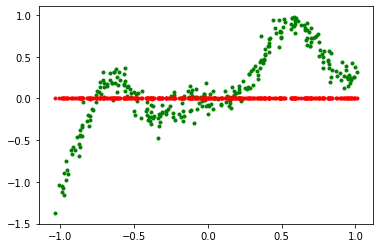

In [39]:
%matplotlib inline

plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, yout.reshape(-1), marker='.', color='r')
plt.show()

In [44]:
optimizer = tnn.SGD()
hdt = DecisionNode(1, 1, optimizer)
hdt.create_child(depth=3)

%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for epoch in range(100000):

    yout = hdt.forward(xx)
    dy = yout - yy
    dx = hdt.backward(dy)
    hdt.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        ax.scatter(x, y, marker='.', color='g')
        ax.scatter(x, yout.reshape(-1), color='r', marker='.')

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.20502730276422748


100 Error =  0.14695391881045058


200 Error =  0.15313736253572552


300 Error =  0.152474045769156


400 Error =  0.15123086203723793


500 Error =  0.1438630119012884


600 Error =  0.14136086397290196


700 Error =  0.13499576703210878


800 Error =  0.1329412579334769


900 Error =  0.13068980959580395


1000 Error =  0.13000342796270487


1100 Error =  0.12930358752015342


1200 Error =  0.12749112849613378


1300 Error =  0.12620468870090135


1400 Error =  0.12618134167960138


1500 Error =  0.1261782136532787


1600 Error =  0.12525459750913442


1700 Error =  0.12525091449819914


1800 Error =  0.12394373630407754


1900 Error =  0.1234500883330981


2000 Error =  0.12139600937223079


2100 Error =  0.12034086739602003


2200 Error =  0.12009935636951323


2300 Error =  0.12009484066046111


2400 Error =  0.12009423564723055


2500 Error =  0.12009415458775465


2600 Error =  0.11988046367199681


2700 Error =  0.12006807916014983


2800 Error



22600 Error =  0.09508419365821656


22700 Error =  0.09416786996062873


22800 Error =  0.0941370090954153


22900 Error =  0.09413287436672817


23000 Error =  0.09341083748242926


23100 Error =  0.09340924113695712


23200 Error =  0.0934090272591098


23300 Error =  0.09356340767996008


23400 Error =  0.09236977624148375


23500 Error =  0.09236374244309846


23600 Error =  0.09236096122424083


23700 Error =  0.09249661730300562


23800 Error =  0.09248926954965518


23900 Error =  0.092420053571471


24000 Error =  0.09241185229087724


24100 Error =  0.09241049065423278


24200 Error =  0.0927063790052138


24300 Error =  0.09269397911694338


24400 Error =  0.09269026615678479


24500 Error =  0.09267712789308731


24600 Error =  0.09268484251957294


24700 Error =  0.09268484031294519


24800 Error =  0.09268632826084572


24900 Error =  0.09268591508046291


25000 Error =  0.09268140005826571


25100 Error =  0.09268053824763664


25200 Error =  0.09267568976419435


2530

44900 Error =  0.06898527371188962


45000 Error =  0.06879964646244649


45100 Error =  0.0678413852791319


45200 Error =  0.06783919158745677


45300 Error =  0.06783886287488497


45400 Error =  0.06726675923713848


45500 Error =  0.0672648296295069


45600 Error =  0.0672645137390951


45700 Error =  0.06726895196766151


45800 Error =  0.06726767629275916


45900 Error =  0.06726692752047195


46000 Error =  0.06726668141777505


46100 Error =  0.06726679128802097


46200 Error =  0.06717687020034509


46300 Error =  0.06723781931783177


46400 Error =  0.06714200953930081


46500 Error =  0.06714068246212941


46600 Error =  0.06716321031170684


46700 Error =  0.06716256204132874


46800 Error =  0.06716247518627426


46900 Error =  0.0671624635494623


47000 Error =  0.06716246199036602


47100 Error =  0.06669698769299064


47200 Error =  0.06667964522424709


47300 Error =  0.06570194185996127


47400 Error =  0.0655377733585758


47500 Error =  0.06567996926826619


47600 



67100 Error =  0.05363180134066328


67200 Error =  0.05324492281477238


67300 Error =  0.0532187879740891


67400 Error =  0.05321557620467806


67500 Error =  0.05321514367121223


67600 Error =  0.05321508572051911


67700 Error =  0.05321507795630409


67800 Error =  0.05321507691605709


67900 Error =  0.05322322477923074


68000 Error =  0.05322296618128824


68100 Error =  0.05322293153441998


68200 Error =  0.05322928870881195


68300 Error =  0.05322569612924805


68400 Error =  0.05322542452022627


68500 Error =  0.05170274948379276


68600 Error =  0.0516796240326037


68700 Error =  0.051676525692172445


68800 Error =  0.05167611057752887


68900 Error =  0.051515132828287166


69000 Error =  0.051507118284982445


69100 Error =  0.05178218605613495


69200 Error =  0.05138074743097718


69300 Error =  0.05136903862511518


69400 Error =  0.05135192985198188


69500 Error =  0.051345983883189956


69600 Error =  0.05155648024212033


69700 Error =  0.05135437149297996

TclError: invalid command name "pyimage62"

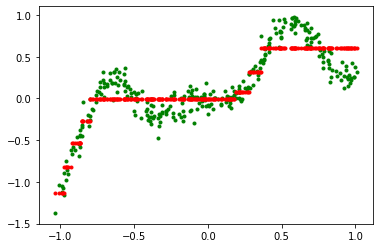

In [43]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, yout.reshape(-1), color='r', marker='.')

## On 2D dataset

In [48]:
matplotlib.rcParams['figure.figsize'] = (12, 8)

In [49]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

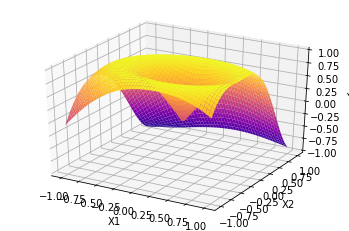

In [50]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [51]:
xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

## Building Decision Tree

In [52]:
optimizer = tnn.Adam()
hdt = DecisionNode(2, 1, optimizer)
hdt.create_child(depth=3)

In [53]:
yout = hdt.forward(xx)

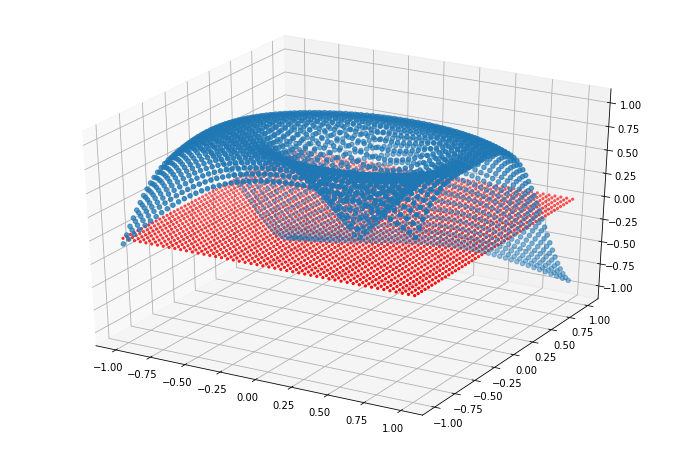

In [54]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
fig.show()

In [56]:
optimizer = tnn.Adam()
hdt = DecisionNode(2, 1, optimizer)
hdt.create_child(depth=3)

%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):

    yout = hdt.forward(xx)
    dy = yout - yy
    dx = hdt.backward(dy)
    hdt.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.5639648664243325


100 Error =  0.09452461599993897


200 Error =  0.06907621453961443


300 Error =  0.06601632075797854


400 Error =  0.06941473949873703


500 Error =  0.07574073941070732


600 Error =  0.08419981670376248


700 Error =  0.07222381043641991


800 Error =  0.05704877492095706


900 Error =  0.05177971366071861


1000 Error =  0.0482854691322804


1100 Error =  0.044547512908670185


1200 Error =  0.043972341816754475


1300 Error =  0.04448046751005902


1400 Error =  0.04237066130568046


1500 Error =  0.04066090744757982


1600 Error =  0.038803195296059516


1700 Error =  0.03953044470999512


1800 Error =  0.04113067314950523


1900 Error =  0.04019655408058928


2000 Error =  0.03954375675558693


2100 Error =  0.039388089758956135


2200 Error =  0.03796320598324084


2300 Error =  0.03666298911388684


2400 Error =  0.0367222922908582


2500 Error =  0.037361778945645734


2600 Error =  0.03829582690385348


2700 Error =  0.03817205996440927


28

TclError: invalid command name "pyimage90"

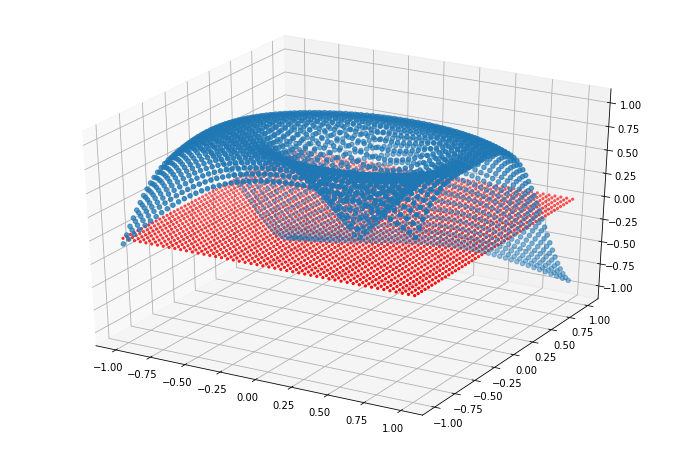

In [55]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
fig.show()

In [20]:
from sklearn.tree import DecisionTreeRegressor

In [21]:
dtr = DecisionTreeRegressor(max_depth=4)

In [22]:
dtr.fit(xx, yy)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [23]:
yout = dtr.predict(xx)

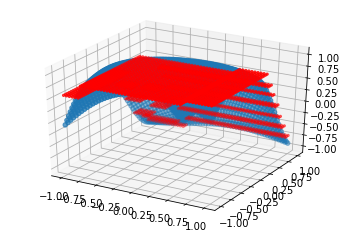

In [24]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
fig.show()